# Time Series with Arima

In this example we consider how to analyze and forecast univariate time-series, i.e. we wish to extract the particularities of a given time-series into a model and use this model to forecast future values.

In this exercise we use an ARIMA model which consists of an autoregressive (AR) term, a moving avarage (MA) term. Such an ARMA model can only be used if the time-series is stationary, i.e. its mean and variance doesn't change. For example, the time series should not have a trend. If the time-series is not stationary, it can often be transformed by differentiating the time-series, i.e. taking the difference between subsequent values. This can be done more than once and the order of differentiation is denoted by d. The inverse of this operation is integration, abbreviated by "I".

Hence, the ARIMA model consists of AR + I + MA. The model includes p AR terms and q MA terms and is hence specfied by (p,d,q).

The auto-regressive term is given by:
$ Y_t = \alpha + \beta_1*Y_{t-1} + \beta_2*Y_{t-2} \ + \cdots + \beta_p*Y_{t-p} + \epsilon_1$
Hence the AR term only depends on the previous values of the time-series, its own lags. $\epsilon$ is a white noise error term, e.g. a random number from a Gaussian Distribution $\epsilon \sim {\mathcal N}(0,\sigma^2)$

The moving average term is very different. It only depends on the error terms at previous times and is given by:
$ Y_t = \alpha + \epsilon_t + \phi_1*\epsilon_{t-1} + \phi_2*\epsilon_{t-2} \cdots + \phi_1*\epsilon_{t-q} $
where $\epsilon_t$ is again the white noise error term at different times, i.e. $\epsilon_t \sim {\mathcal N}(0,\sigma^2)$

The following data was obtained from Google Trends which shows the search volume of a given term on the Google search engine.
In this example, the term "common cold" was chosen as this is expected to show a strong seasonal behaviour as well an regular pattern which isn't influenced by hypes too much.


We notice that the time series of the search volume of "common cold" shows a regular pattern as well as a trend.

Before running this notebook, please download the relevant data 

In [ ]:
# relevant packages

#Pandas for data handling
import pandas as pd

# for data manipulation
import numpy as np

#Matplotlib for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# time series modeling
import statsmodels.api
import statsmodels as sm

#plots for (partial) autocorrelaton
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf




## Load the data
From Google trends, the time series data can be downloaded and looks like this:
```
Category: All categories

Month,Common cold: (Worldwide)
2004-01,37
2004-02,32
2004-03,26
....
```

The first line contains some additional information about the search query, the second line is empty, the third line contains the decription of the data columns.
The actual data starts in the fourth line. The data about the search volume is provided on a monthly basis and the month and corresponding search volume is separated by a comma.

When we want to work with the data, we need to skip the first three rows to get to the actual data.

In the following, we use the ```pandas``` package to read and manipulate the data.

Note that you will have to adapt the path and filename to where you have placed the data file.

In [ ]:
df = pd.read_csv('data/GoogleTrends_CommonCold.csv',sep=',',header=None, skiprows=3,
                names=['year_month', 'search_volume'])

In [ ]:
# look at the first 5 rows of data
df.head(5)

,year_month,search_volume
0,2004-01,37
1,2004-02,32
2,2004-03,26
3,2004-04,24
4,2004-05,22


The time which corresponds to the search volume is given as a string in the format ```YYYY-MM```. In a first step, we split year and month and convert these to integer numbers.


In [ ]:
split = df['year_month'].str.split('-')
df['year'] = split.str[0].astype(np.int32)
df['month'] = split.str[1].astype(np.int32)

In [ ]:
#lets look if that worked
df.head(5)

,year_month,search_volume,year,month
0,2004-01,37,2004,1
1,2004-02,32,2004,2
2,2004-03,26,2004,3
3,2004-04,24,2004,4
4,2004-05,22,2004,5


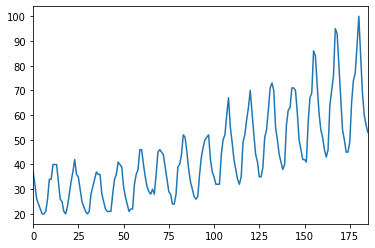

In [ ]:
# let's look at the data as a time-series
df['search_volume'].plot()

This works but you're not alone if you feel that this is a bit crude... It's nicer to convert the string "year_month" into a timestamp object which Pandas knows how to handle automatically as well.

For this we have to convert each string into a a timestamp. The basic syntax is:

timestamp = pd.Timestamp(string)
We could loop over the whole DataFrame, however, this is quite tedious - and slow as well as we'd have to do the loop manually. Pandas offers a dedicated functionality to work on each row of the DataFrame - but instead of us writing the loop, Pandas does it automatically in the background in an optimised way.

The basic syntax is:

```python
X['NewColumn'] = X['Column_as_input'].appy(do_something)
```

We now need the content of the row in each case to pass to the Timestamp function - this is what the little trick with the "lambda function" does for us.

In [ ]:
df['timestamp'] = df['year_month'].apply(lambda x : pd.Timestamp(x))
df.set_index('timestamp', inplace=True)
df.head()

,year_month,search_volume,year,month
timestamp,,,,
2004-01-01,2004-01,37,2004,1
2004-02-01,2004-02,32,2004,2
2004-03-01,2004-03,26,2004,3
2004-04-01,2004-04,24,2004,4
2004-05-01,2004-05,22,2004,5


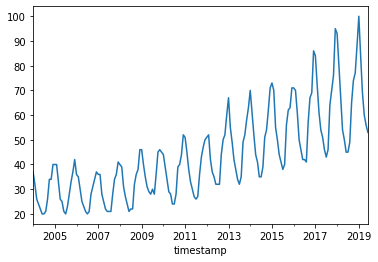

In [ ]:
df['search_volume'].plot()

# Split into train and test sample

We now split the time series into two independent samples, the training sample and the test sample
The training sample is the majority of the data and runs from the beginning to 2016, the test sample is the rest.


In [ ]:
#the full data sample - see how well it works when no independent data is taken for verification
#train=df.iloc[0:len(df)]

#split the data so that some data are taken for training and the rest is independent and used for testing
train=df['search_volume']['2004-01-01':'2016-12-01']
test=df['search_volume']['2017-01-01':]

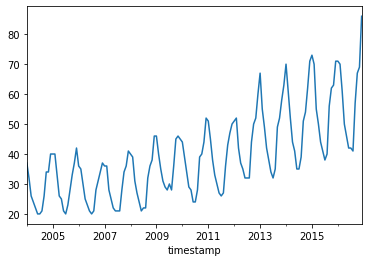

In [ ]:
train.plot()

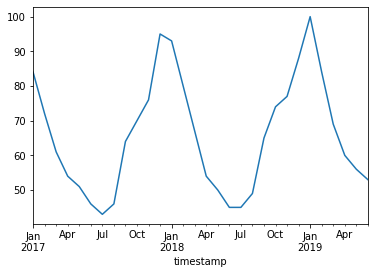

In [ ]:
test.plot()


## Trend analysis

Looking at the plot of the time series we notice a strong trend: The overall search volume increases rapidly 
with time. The statsmodel package allows to conveniently decompose the original time-series into a trend and the residual.

In [ ]:
seasonal = sm.tsa.seasonal.seasonal_decompose(train, model='multiplicative', extrapolate_trend=1)

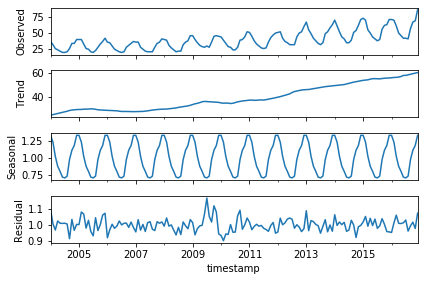

In [ ]:
seasonal.plot()
plt.show()

First we notice that there is a strong 12-month seasonality.

We notice that the trend is approximately linear  and the residuals then fluctuate
around this. The trend looks like this:



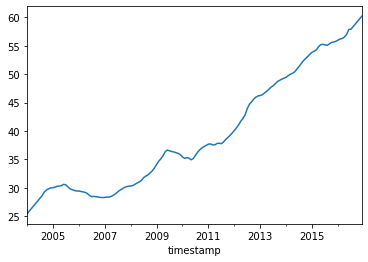

In [ ]:
seasonal.trend.plot()

## Order of the ARIMA model

An ARIMA model is defined by 3 numbers (p,d,q) where 
 * p : order of AR terms
 * d : order of differentiation
 * q : order of MA terms
 
From the seasonal analysis above we remember that we have seen an approximately linear trend.  We could remove this trend ourselves beforehand by e.g. fittign a linear model or taking the above  trend and divide through this trend model.
 
### Differentiation
Here we take the approach of differentiation to make the model stationary. Since we observe a linear trend, we take d=1
 (not that the differentiation should be used with care and taken with some caution in order to avoid over-differentiation of the model).
 
As a first visual cue, we take the first order of differentiation (d=1) and look at the time-series as well as the auto-correlation plot.
The time-series should then be stationary and the auto-correlation should drop to zero quickly (i.e. come within the shaded area which is compatible with zero). After the first level of differentiation, this seems to be fulfilled

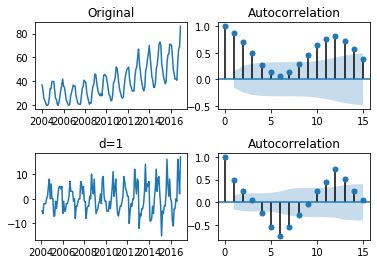

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(train); axes[0, 0].set_title('Original')
plot_acf(train, ax=axes[0, 1], lags=15)

axes[1, 0].plot(train.diff()); axes[1, 0].set_title('d=1')
plot_acf(train.diff().dropna(), ax=axes[1, 1], lags=15)

plt.subplots_adjust(hspace=0.5)
plt.show()

In order to confirm that one order of differentation (d=1) is sufficient we use an ARIMA model with p=q=0 (i.e. a constant) and only a differentiation. After this step, the resulting time series should be stationary:


In [ ]:
mod = sm.api.tsa.statespace.SARIMAX(train,
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        32.8182      3.443      9.533      0.000      26.071      39.566


/home/ulik/VirtualEnvs/TSEnv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/ulik/VirtualEnvs/TSEnv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/home/ulik/VirtualEnvs/TSEnv/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


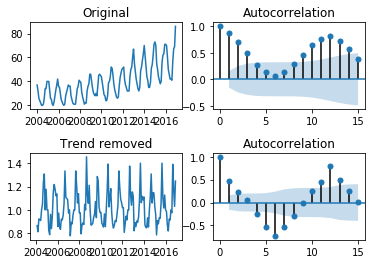

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2004-01-01'), dynamic=False)
detrend = df['search_volume']/pred.predicted_mean

#due to the differentiation the first value is no longer defined and we need to remove it from the time series
detrend = detrend.replace([np.inf, -np.inf], np.nan).dropna()
#detrend.plot()
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(train); axes[0, 0].set_title('Original')
plot_acf(train, ax=axes[0, 1], lags=15)

axes[1, 0].plot(detrend); axes[1, 0].set_title('Trend removed')
plot_acf(detrend, ax=axes[1, 1], lags=15)

plt.subplots_adjust(hspace=0.5)
plt.show()

The linearly rising trend is now removed. We keep d=1.

### Order of AR and MA
Now we need to determine the order of the AR and the MA terms. First we need
to verify that an ARIMA model is a valid approach. 
Remember that Box and Jenkins have proven that for a AR(n) model the auto-correlation either falls exponentially or shows a damped osciallation. Looking at the auto-correlation in this example we have the latter case and hence we can use an AR time series model.

The auto-correlation plot of the stationary time-series (without the trend) looks like this:



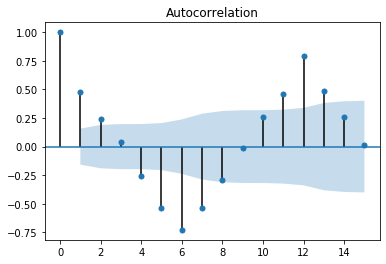

In [ ]:
plot_acf(detrend, lags=15)

plt.show()

We determine the order p of the AR part of the model first.  For this we look at the auto-correlation plot again and look where which lags are siginficant, i.e. haven't yet crossed into the shaded area which indicate that the value is compatible with zero.

In our case we determine $p=2$.

Next we need to look at the partial auto-correlation plot to determine the order q of the MA part. 
The plot looks like this:

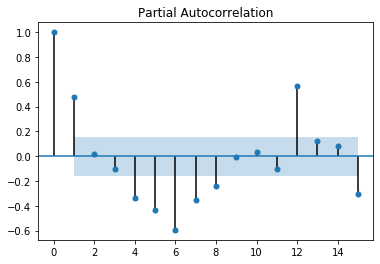

In [ ]:
plot_pacf(detrend, lags=15)
plt.show()

Again we look which part is significant and hasn't crossed into the shaded area, i.e. $q=1$

We also note:
There is a strong seasonal component at 12 months which is again shown in the partial auto-correlation plot.
(There is also one for 6 months but that is presumably just an artefact from the strong yearly seasonal effect looking at the original time seriesn and the seasonal decomposition)

Hence in total we have:
 * $p=2$
 * $d=1$
 * $q=1$
 * 12 months saisonality
 
 We now fit the time-series with the above model. Rather than using the values with the trend removed we use the original series and include the linear trend in the model.

In [ ]:
mod = sm.api.tsa.statespace.SARIMAX(train,
                                order=(2, 1, 1), #p,d,q
                                seasonal_order=(2, 0, 1, 12), #set d=1 in seasonal model to avoid over-differentiation
                                trend='ct', #linear trend
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/home/ulik/VirtualEnvs/TSEnv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/ulik/VirtualEnvs/TSEnv/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4846      0.588      0.824      0.410      -0.668       1.638
drift         -0.0037      0.006     -0.631      0.528      -0.015       0.008
ar.L1         -0.9360      0.316     -2.963      0.003      -1.555      -0.317
ar.L2         -0.3820      0.149     -2.570      0.010      -0.673      -0.091
ma.L1          2.0336      1.344      1.513      0.130      -0.601       4.668
ar.S.L12       0.8115      0.114      7.092      0.000       0.587       1.036
ar.S.L24       0.2723      0.118      2.304      0.021       0.041       0.504
ma.S.L12      -0.6218      0.097     -6.378      0.000      -0.813      -0.431
sigma2         1.5095      2.049      0.737      0.461      -2.507       5.526


/home/ulik/VirtualEnvs/TSEnv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


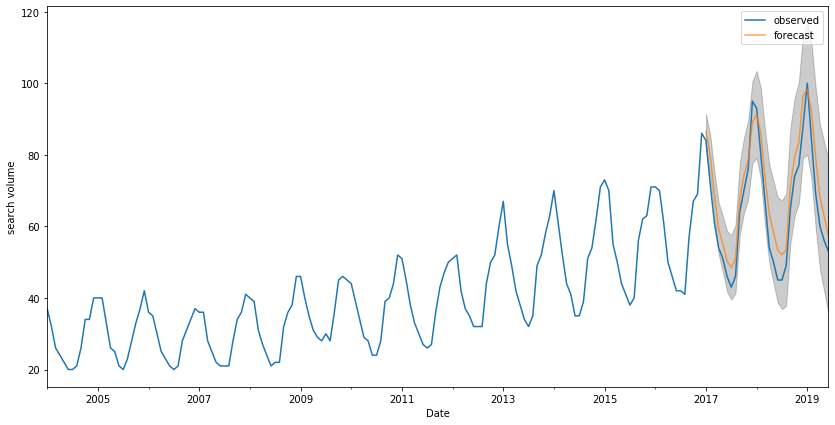

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2019-06-01'))
pred_ci = pred.conf_int()
ax = df['search_volume'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('search volume')
plt.legend()
plt.show()


We notice that the resulting forecasts are reasonable - but not extremely precise.
The confidence intervals are cover the observed true values in the test sample, however, the predictinos themselves don't quite follow the observed values.

Potential next steps could be:
 * optimise the SARIMA parameters: So far we have use the ACP and PACF plot to manually determine p and q, this could be done in a search to optimize these hyperparameters, e.g. using a grid-search of the parameters or an auto-arima approach: Several packages allow the automatic optimization of the model parameters (e.g. pmdarima)
 * use a more compolex model
 * use a more powerful forecasting approach